In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv', 'train_images', 'test_images']


In [2]:
import cv2

X_img = []
y_p = []
def create_training_set(label, path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    X_img.append(np.array(img))
    y_p.append(str(label))

In [3]:
df_train = pd.read_csv('../input/train.csv')

In [4]:
X = df_train['id_code']
y = df_train['diagnosis']

In [5]:
from tqdm import tqdm

TRAIN_DIR = '../input/train_images'
for id_code, diagnosis in tqdm(zip(X,y)):
    path = os.path.join(TRAIN_DIR, '{}.png'.format(id_code))
    create_training_set(diagnosis, path)

3662it [04:27, 12.72it/s]


In [6]:
from keras.utils import to_categorical

Y = to_categorical(y_p)
X= np.array(X_img)
X=X/255

Using TensorFlow backend.


Feature Extraction

In [7]:
from keras.preprocessing.image import ImageDataGenerator

feat_extraction = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
feat_extraction.fit(X)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=22)

    

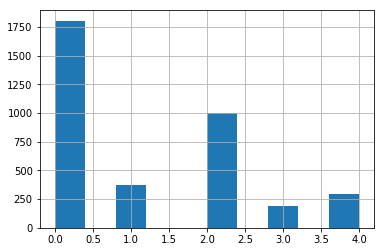

In [9]:
y.hist()

#Modelling

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, GaussianDropout
from keras.constraints import maxnorm
from keras import regularizers, optimizers

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())

model.add(Dense(5, activation='softmax'))


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [12]:
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop

model.compile(optimizer= Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
batch_size =50
epochs= 50

In [14]:
from keras.callbacks import ModelCheckpoint

checkpointer =  ModelCheckpoint(filepath= 'CNN_keras.hdf5', verbose=1, save_best_only=True)

#model_history = model.fit_generator(feat_extraction.flow(X_train, Y_train, batch_size=batch_size),
 #        epochs= epochs, validation_data=feat_extraction.flow(X_valid, Y_valid, batch_size= batch_size),
  #       callbacks= [checkpointer], verbose=1, steps_per_epoch=X_train.shape[0]//batch_size, validation_steps=X_train.shape[0]//batch_size )


model_history=model.fit(X_train, Y_train, 
          validation_data=(X_valid, Y_valid),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)




Train on 2929 samples, validate on 733 samples
Epoch 1/50
2929/2929 [==============================] - 6s 2ms/step - loss: 1.3452 - acc: 0.4862 - val_loss: 1.2831 - val_acc: 0.4789

Epoch 00001: val_loss improved from inf to 1.28314, saving model to CNN_keras.hdf5
Epoch 2/50
2929/2929 [==============================] - 2s 749us/step - loss: 1.2305 - acc: 0.4985 - val_loss: 1.2411 - val_acc: 0.4870

Epoch 00002: val_loss improved from 1.28314 to 1.24112, saving model to CNN_keras.hdf5
Epoch 3/50
2929/2929 [==============================] - 2s 737us/step - loss: 1.1764 - acc: 0.5189 - val_loss: 1.1659 - val_acc: 0.5266

Epoch 00003: val_loss improved from 1.24112 to 1.16590, saving model to CNN_keras.hdf5
Epoch 4/50
2929/2929 [==============================] - 2s 734us/step - loss: 1.1221 - acc: 0.5797 - val_loss: 1.1446 - val_acc: 0.5512

Epoch 00004: val_loss improved from 1.16590 to 1.14465, saving model to CNN_keras.hdf5
Epoch 5/50
2929/2929 [==============================] - 2s 728u

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


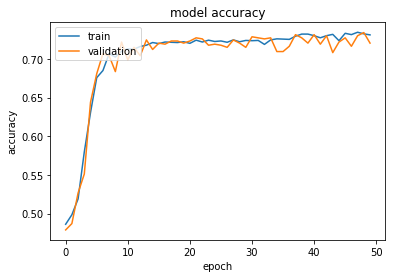

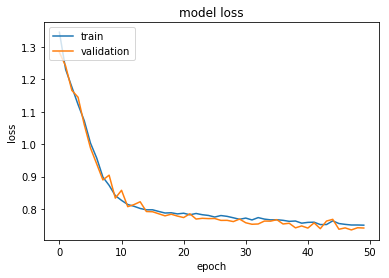

In [15]:
import matplotlib.pyplot as plt
# list all data in history
print(model_history.history.keys())
# summarize history for accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
os.listdir('../input/test_images/')[0:5]

['3d4d693f7983.png',
 'bc9d8ac89c82.png',
 'ab59dfa8dfa2.png',
 'd8ebfa3568ac.png',
 '1e0309115a25.png']

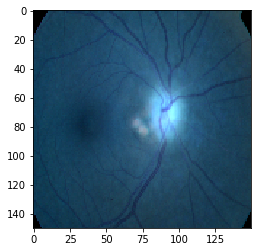

In [17]:
test_image = cv2.imread('../input/test_images/3d4d693f7983.png', cv2.IMREAD_COLOR)
test_image = cv2.resize(test_image, (150,150))
import matplotlib.pyplot as plt

plt.imshow(test_image)

In [18]:
test_X = np.array(test_image)
test_X = test_X/255

In [19]:
pred_test= model.predict(np.expand_dims(test_X,axis=0))

In [20]:
pred_test

array([[0.10197716, 0.12064256, 0.4210069 , 0.17770542, 0.1786679 ]],
      dtype=float32)

In [21]:
test_df = pd.read_csv('../input/test.csv')
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [22]:
test_ids = test_df['id_code']

In [23]:
test_images = []
def create_test_set(path):
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))

    test_images.append(np.array(img))

In [24]:
from tqdm import tqdm
for id_code in tqdm(test_ids):
    path = os.path.join('../input/test_images','{}.png'.format(id_code))
    create_test_set(path)

100%|██████████| 1928/1928 [00:49<00:00, 38.72it/s]


In [25]:
from keras.models import load_model
model=load_model('CNN_keras.hdf5')

In [26]:
test_X=np.array(test_images)
test_X=test_X/255
feat_extraction.fit(test_X)
predictions=model.predict(test_X)

In [27]:
pred = np.argmax(predictions, axis=1)
pred

array([2, 2, 2, ..., 2, 2, 0])

In [28]:
np.unique(pred)

array([0, 1, 2])

In [29]:
submission_cnn = pd.DataFrame({'id_code' : test_ids , 'diagnosis' : pred})

In [30]:
submission_cnn.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [31]:
submission_cnn.to_csv("submission.csv",index=False)